# Displacement - Strain - Stress due to point load at the surface (solution by elastic FEM)

© 2022 Exneyder A. Montoya-Araque, Daniel F. Ruiz and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/eamontoyaa/EAFIT_foundation_eng/blob/main/notebooks/point_load.ipynb).

This notebook depends on:
* SolidsPy V1.0.16 [Guarín-Zapata et al. (2020)](https://doi.org/10.5281/zenodo.4029270)
* pygmsh V6.0.2 [Schlömer et al. (2019a)](https://doi.org/10.5281/zenodo.3541027)
* meshio V3.3.1 [Schlömer et al. (2019b)](https://doi.org/10.5281/zenodo.3584511)
* And other packages for general scientific programming in Python


## Setting up the environment

Uncomment the following lines and run the cell to install the dependencies.

In [1]:
# !sudo apt-get install -y python-gmsh
# !pip install meshio==3.3.1
# !pip install pygmsh==6.0.2
# !pip install solidspy==1.0.16

## Required modules

In [2]:
import pygmsh
import meshio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import solidspy.preprocesor as pre
import solidspy.postprocesor as pos
import solidspy.assemutil as ass
import solidspy.solutil as sol


## Global configuration for plots

In [3]:
plt.style.use("default")
plt.rcParams["image.cmap"] = "Set1"
mpl.rcParams.update(
    {
        "font.family": "serif",  # Use the Computer modern font
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
        "image.cmap": 'PiYG'
    }
)


## Functions

### Creating the domain and meshing it

In [4]:
def create_domain(x_0=0, y_0=0, l=20, z=10, elem_size=1.0):
    # Empty structure
    geom = pygmsh.built_in.Geometry()
    # Points
    p1 = geom.add_point([x_0 + 0.0, y_0 + 0.0, 0.0], elem_size)
    p2 = geom.add_point([x_0 - l / 2, y_0 + 0.0, 0.0], elem_size)
    p3 = geom.add_point([x_0 - l / 2, y_0 - z, 0.0], elem_size)
    p4 = geom.add_point([x_0 + l / 2, y_0 - z, 0.0], elem_size)
    p5 = geom.add_point([x_0 + l / 2, y_0 + 0, 0.0], elem_size)
    # Lines
    l1 = geom.add_line(p1, p2)  # Upper line 1
    l2 = geom.add_line(p2, p3)  # Rigth line
    l3 = geom.add_line(p3, p4)  # Bottom line
    l4 = geom.add_line(p4, p5)  # Left line
    l5 = geom.add_line(p5, p1)  # Upper line 2
    # Surfaces
    ll1 = geom.add_line_loop([l1, l2, l3, l4, l5])
    s1 = geom.add_plane_surface(ll1)
    # Physical groups
    geom.add_physical(s1, label="100")  # Material
    geom.add_physical(p1, label="200")  # Point load
    geom.add_physical([l2, l4], label="300")  # Lateral boundary
    geom.add_physical(l3, label="400")  # Lower boundary
    geom.add_physical([l5, l1], label="500")  # Upper boundary
    # Generate the mesh
    mesh = pygmsh.generate_mesh(
        geom, geo_filename="mesh.geo", msh_filename="mesh.msh"
    )
    return mesh


### Creating solidspy inputs

In [5]:
def solidspy_inputs(mesh, elasticity_mod, poisson_rat, load_x, load_y):
    """Loads in [N/m] located in the node at (x_0, y_0)"""
    points = mesh.points
    cells = mesh.cells
    point_data = mesh.point_data
    cell_data = mesh.cell_data
    field_data = mesh.field_data
    # Element data
    eles = cells["triangle"]
    els_array = np.zeros([eles.shape[0], 6], dtype=int)
    els_array[:, 0] = range(eles.shape[0])
    els_array[:, 1] = 3
    els_array[:, 3::] = eles.data
    # Nodes
    nodes_array = np.zeros([points.shape[0], 5])
    nodes_array[:, 0] = range(points.shape[0])
    nodes_array[:, 1:3] = points[:, :2]
    # Loads
    id_cargas = cells["vertex"]
    loads_array = np.array([[id_cargas[0][0], load_x, load_y]])
    # Boundaries
    lines = cells["line"]
    bounds = cell_data["line"]["gmsh:physical"]
    nbounds = len(bounds)
    id_izq_der = [cont for cont in range(nbounds) if bounds[cont] == 3]
    id_inf = [cont for cont in range(nbounds) if bounds[cont] == 4]
    nodes_izq_der = lines[id_izq_der].flatten()
    nodes_inf = lines[id_inf].flatten()
    nodes_array[nodes_izq_der, 3] = -1
    nodes_array[nodes_inf, 3:] = (-1, -1)
    #  Material
    mats_array = np.array([[elasticity_mod, poisson_rat]])
    return (nodes_array, mats_array, els_array, loads_array)


### Executing the solver

In [6]:
def run_solidspy(nodes, mats, elements, loads):
    # System assembly
    assem_op, bc_array, neq = ass.DME(nodes, elements)
    stiff_mat = ass.assembler(elements, mats, nodes, neq, assem_op)
    rhs_vec = ass.loadasem(loads, bc_array, neq)
    # System solution
    disp = sol.static_sol(stiff_mat, rhs_vec)
    # Post-processing
    # Fill the displacement vectors with imposed and computed values
    disp = pos.complete_disp(bc_array, nodes, disp)
    # Averaged strains and stresses at nodes
    strain, stress = pos.strain_nodes(nodes, elements, mats, disp)
    # Compute the principal directions of a tensor field
    eigs1, eigs3, vecs1, vecs3 = pos.principal_dirs(stress)
    return (disp, strain, stress, eigs1, eigs3, vecs1, vecs3)


## Running a case

In [7]:
# Creating the domain and meshing it
mesh = create_domain(x_0=0, y_0=0, l=20, z=10, elem_size=0.5)
# Creating solidspy inputs
nodes, mats, elements, loads = solidspy_inputs(
    mesh, elasticity_mod=50e6, poisson_rat=0.3, load_x=0, load_y=-1e9
)
# Executing the solver
disp, strain, stress, eigs1, eigs3, vecs1, vecs3 = run_solidspy(
    nodes, mats, elements, loads
)


Info    : Running '/home/eamontoyaa/.pyenv/versions/3.9.13/envs/solidspy-env/bin/gmsh -3 mesh.geo -format msh -bin -o mesh.msh' [Gmsh 4.10.5, 1 node, max. 1 thread]
Info    : Started on Wed Aug  3 17:15:31 2022
Info    : Reading 'mesh.geo'...
Info    : Done reading 'mesh.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.000540118s, CPU 0.002629s)
Info    : Meshing 2D...
Info    : Meshing surface 7 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0317391s, CPU 0.147579s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 2.2476e-05s, CPU 1.4e-05s)
Info    : 995 nodes 1993 elements
Info    : Writing 'mesh.msh'...
Info    : Done writing 'mesh.msh'
Info    : Stopped on Wed Aug  3 17:15:31 2022 (From start: Wall 0.049842s, CPU 0.696279s)

msh file: mesh.msh

geo fil

## Plotting results

### Displacements

/home/eamontoyaa/.pyenv/versions/3.9.13/envs/solidspy-env/lib/python3.9/site-packages/solidspy/postprocesor.py:108: UserWarning: The following kwargs were not used by contour: 'shading'
  disp_plot(tri, field, levels, shading="gouraud")


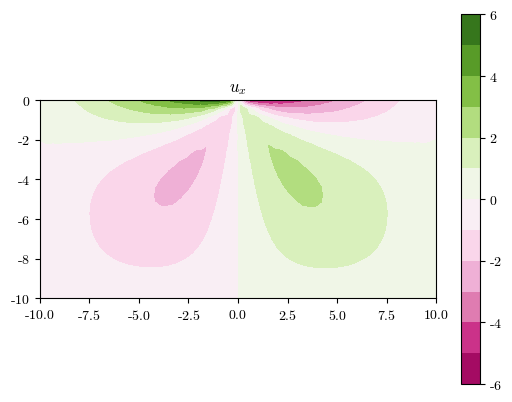

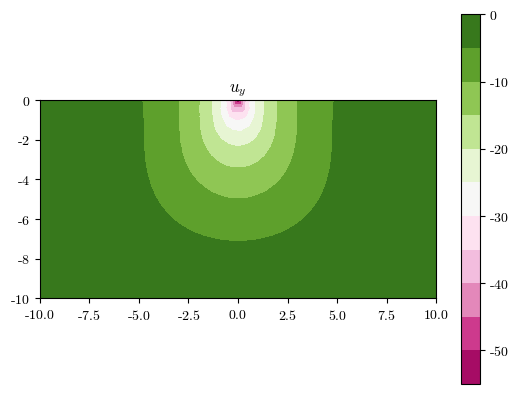

In [8]:
pos.plot_node_field(disp, nodes, elements, title=["$u_x$", "$u_y$"]);

### Strain

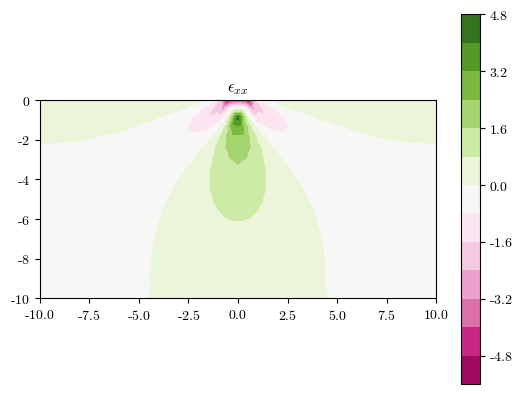

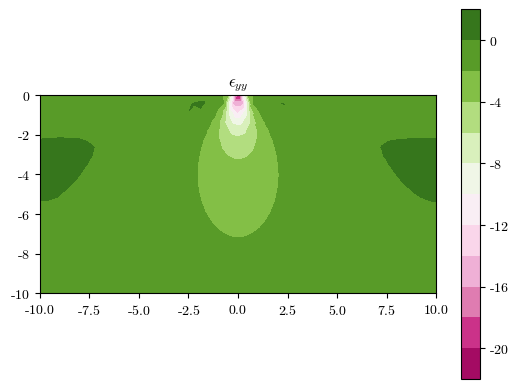

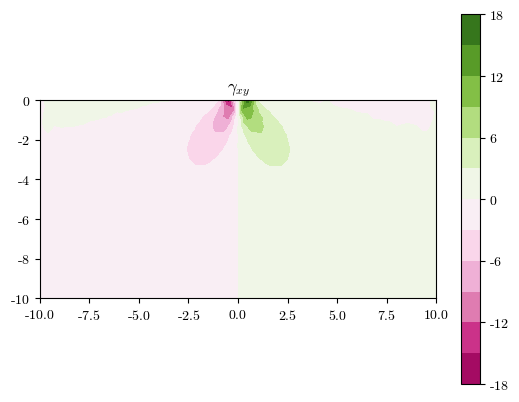

In [9]:
pos.plot_node_field(
    strain,
    nodes,
    elements,
    title=[
        "$\epsilon_{xx}$",
        "$\epsilon_{yy}$",
        "$\gamma_{xy}$",
    ],
)


### Cartesian stress

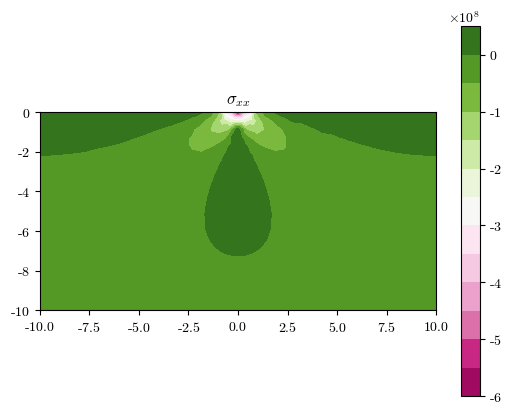

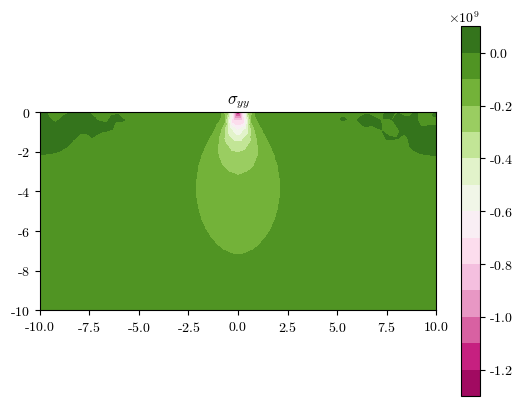

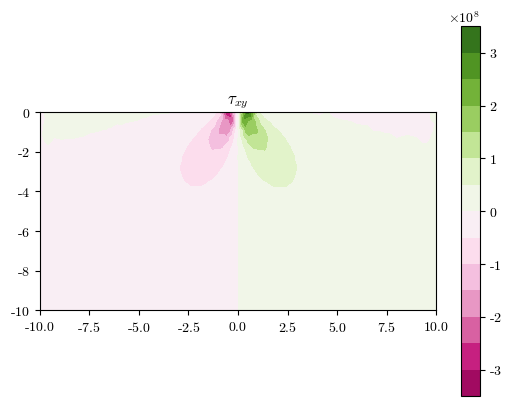

In [10]:
pos.plot_node_field(
    stress,
    nodes,
    elements,
    title=[
        "$\sigma_{xx}$",
        "$\sigma_{yy}$",
        "$\\tau_{xy}$",
    ],
)


### Principal stress and directions

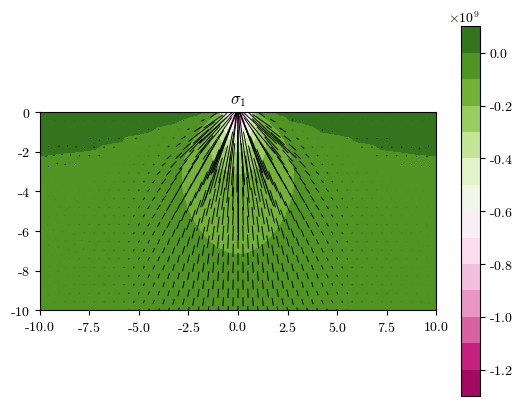

In [11]:
x, y = nodes[:, 1:3].T
pos.plot_node_field(eigs1, nodes, elements, title=['$\sigma_1$']);
plt.quiver(x, y, *eigs1*vecs1.T, headwidth=0);
plt.quiver(x, y, *-eigs1*vecs1.T, color='k', headwidth=0);

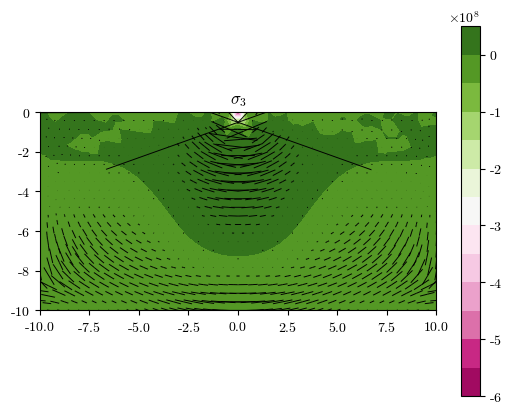

In [12]:
pos.plot_node_field(eigs3, nodes, elements, title=['$\sigma_3$']);
plt.quiver(x, y, *eigs3*vecs3.T, units='width', headwidth=0);
plt.quiver(x, y, *-eigs3*vecs3.T, color='k', units='width', headwidth=0);